In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7
%pylab inline
%load_ext autoreload
%autoreload 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import json
import torch
from tqdm import tqdm
import seaborn as sns
from sklearn.manifold import TSNE

In [4]:
from ssl_neuron.datasets import GraphDataset
from ssl_neuron.utils import plot_neuron, plot_tsne, neighbors_to_adjacency_torch, compute_eig_lapl_torch_batch, compute_eigvec_of_euclidean_dist_matrix, pos_enc_from_eigvec_of_conductive_dist_matrix
from ssl_neuron.graphdino import create_model

In [6]:
config = json.load(open('./ssl_neuron/configs/config_BBP_allPE.json'))
config

{'model': {'num_classes': 1000,
  'dim': 32,
  'depth': 7,
  'n_head': 8,
  'pos_dim': 32,
  'move_avg': 0.999,
  'center_avg': 0.9,
  'teacher_temp': 0.06},
 'data': {'class': 'BBP',
  'path': '/usr/users/agecker/datasets/neuron_morphology_markram/',
  'n_nodes': 200,
  'feat_dim': 3,
  'batch_size': 64,
  'num_workers': 6,
  'jitter_var': 1,
  'translate_var': 10,
  'rotation_axis': 'y',
  'n_drop_branch': 10},
 'optimizer': {'lr': 0.0001, 'max_iter': 80000, 'exp_decay': 0.5},
 'trainer': {'ckpt_dir': 'ssl_neuron/ckpts_allPE/',
  'save_ckpt_every': 200,
  'seed': None}}

In [7]:
model = create_model(config)

In [8]:
state_dict = torch.load(config['trainer']['ckpt_dir']+'ckpt_9800.pt', map_location=torch.device(0))

In [10]:
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [12]:
model.eval()
model.cuda();

In [13]:
dset = GraphDataset(config, mode='all', inference=True, storage='/user/makhmet1/ssl_neuron/ssl_neuron/dset.pkl')

In [18]:
# # Uncomment for pstepRWPE+euclPE
# latents = np.zeros((dset.num_samples, config['model']['dim']))

# for i in tqdm(range(dset.num_samples)):
#     feat, neigh, soma_id = dset.__getsingleitem__(i)
#     adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None, ]
#     feat = torch.from_numpy(feat).float().cuda()[None, ]
#     ed = compute_eigvec_of_euclidean_dist_matrix(feat)
#     eig_val, eig_vec = torch.linalg.eigh(ed)
#     eig_vec = torch.flip(eig_vec, dims=[2])
#     pos_enc_dim = 32
#     pos_enc = eig_vec[:, :, 1:pos_enc_dim + 1]
#     lapl = pos_enc
    
#     latents[i] = model.student_encoder.forward(feat, adj, lapl)[0].cpu().detach()

In [19]:
# # # Uncomment for eucl_distPE
# latents = np.zeros((dset.num_samples, config['model']['dim']))

# for i in tqdm(range(dset.num_samples)):
#     feat, neigh, soma_id = dset.__getsingleitem__(i)
#     adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None, ]
#     feat = torch.from_numpy(feat).float().cuda()[None, ]
#     ed = compute_eigvec_of_euclidean_dist_matrix(feat)
#     eig_val, eig_vec = torch.linalg.eigh(ed)
#     eig_vec = torch.flip(eig_vec, dims=[2])
#     pos_enc_dim = 32
#     pos_enc = eig_vec[:, :, 1:pos_enc_dim + 1]
#     lapl = pos_enc
    
#     latents[i] = model.student_encoder.forward(feat, adj, lapl)[0].cpu().detach()

In [20]:
# # # Uncomment for lapPE
# latents = np.zeros((dset.num_samples, config['model']['dim']))

# for i in tqdm(range(dset.num_samples)):
#     feat, neigh, soma_id = dset.__getsingleitem__(i)
#     adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None, ]
#     lapl = compute_eig_lapl_torch_batch(adj, pos_enc_dim=config['model']['pos_dim']).float().cuda()
#     feat = torch.from_numpy(feat).float().cuda()[None, ]
#     eig_val, eig_vec = torch.linalg.eigh(lapl)
#     eig_vec = torch.flip(eig_vec, dims=[2])
#     pos_enc_dim = 32
#     pos_enc = eig_vec[:, :, 1:pos_enc_dim + 1]
#     lapl = pos_enc
    
#     latents[i] = model.student_encoder.forward(feat, adj, lapl)[0].cpu().detach()

In [21]:
# # # Uncomment for pstepRWPE
# latents = np.zeros((dset.num_samples, config['model']['dim']))

# for i in tqdm(range(dset.num_samples)):
#     feat, neigh, soma_id = dset.__getsingleitem__(i)
#     adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None, ]
#     feat = torch.from_numpy(feat).float().cuda()[None, ]
#     lapl = 0
    
#     latents[i] = model.student_encoder.forward(feat, adj, lapl)[0].cpu().detach()

In [22]:
# # # # Uncomment for cond_distPE
# latents = np.zeros((dset.num_samples, config['model']['dim']))

# for i in tqdm(range(dset.num_samples)):
#     feat, neigh, soma_id = dset.__getsingleitem__(i)
#     adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None, ]
#     feat = torch.from_numpy(feat).float().cpu()[None, ]
#     cd = pos_enc_from_eigvec_of_conductive_dist_matrix(feat, adj.cpu(), torch.device(0))
#     eig_val, eig_vec = torch.linalg.eigh(cd)
#     eig_vec = torch.flip(eig_vec, dims=[2])
#     pos_enc_dim = 32
#     pos_enc = eig_vec[:, :, 1:pos_enc_dim + 1]
#     lapl = pos_enc
    
#     latents[i] = model.student_encoder.forward(feat.cuda(), adj.cuda(), lapl)[0].cpu().detach()

In [23]:
# # # # Uncomment for allPE. Important!!! Remember to change the next line in the graphdino.py 
#lapl, cond, eucl = torch.split(lapl, 1, dim=0) #128 is the combined batch size. Change 128 to 1.
latents = np.zeros((dset.num_samples, config['model']['dim']))

for i in tqdm(range(dset.num_samples)):
    feat, neigh, soma_id = dset.__getsingleitem__(i)
    adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None, ]
    feat = torch.from_numpy(feat).float().cpu()[None, ]
    cd = pos_enc_from_eigvec_of_conductive_dist_matrix(feat, adj.cpu(), torch.device(0))
    #feat_cuda = torch.from_numpy(feat).float().cuda()[None, ]
    #ed = compute_eigvec_of_euclidean_dist_matrix(feat)
    ed = compute_eigvec_of_euclidean_dist_matrix(feat.cuda())
    lapl = compute_eig_lapl_torch_batch(adj, pos_enc_dim=config['model']['pos_dim']).float().cuda()
    l1 = torch.cat((lapl, cd, ed), dim=0)
    eig_val, eig_vec = torch.linalg.eigh(l1)
    eig_vec = torch.flip(eig_vec, dims=[2])
    pos_enc_dim = 32
    pos_enc = eig_vec[:, :, 1:pos_enc_dim + 1]
    lapl = pos_enc
    
    latents[i] = model.student_encoder.forward(feat.cuda(), adj.cuda(), lapl)[0].cpu().detach()

100%|███████████████████████████████████████████████████████████████████| 616/616 [06:45<00:00,  1.52it/s]


In [24]:
# # # Uncomment for no_PE
# latents = np.zeros((dset.num_samples, config['model']['dim']))

# for i in tqdm(range(dset.num_samples)):
#     feat, neigh, soma_id = dset.__getsingleitem__(i)
#     adj = neighbors_to_adjacency_torch(neigh, list(neigh.keys())).float().cuda()[None, ]
#     feat = torch.from_numpy(feat).float().cpu()[None, ]
#     lapl = 0
    
#     latents[i] = model.student_encoder.forward(feat.cuda(), adj.cuda(), lapl)[0].cpu().detach()

In [25]:
latents.shape

(616, 32)

<ErrorbarContainer object of 3 artists>

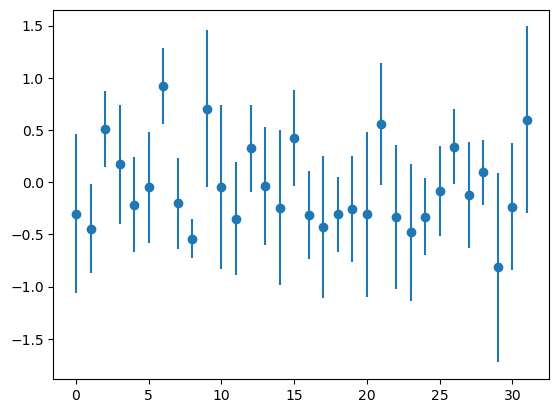

In [28]:
plt.scatter(np.arange(config['model']['dim']), latents.mean(axis=0))

plt.errorbar(np.arange(config['model']['dim']), latents.mean(axis=0), yerr = latents.std(axis=0), fmt='none')

In [29]:
import os
import pandas as pd
import numpy as np

df = pd.read_pickle('/usr/users/agecker/datasets/neuron_morphology_markram/markram_overview.pkl')

selected_cells = df[df['binary_cell_type'].notna() & df['binary_cell_type'].isin(['inh', 'exc'])]

cls_target = np.ones(dset.num_samples, dtype=int)

for i in range(dset.num_samples):
    exc_or_inh = selected_cells.loc[selected_cells['cell_id'] == dset.cells[i]['cell_id'], 'binary_cell_type'].iloc[0]
    if exc_or_inh=='inh':
        cls_target[i] = int(0)
cls_target

array([0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,

In [31]:
import numpy as np



val_ids = np.load('/user/makhmet1/ssl_neuron/ssl_neuron/data_BBP/val_ids.npy', allow_pickle=True)


target = np.zeros(dset.num_samples, dtype=int)


for i in range(dset.num_samples):
    cell_id = dset.cells[i]['cell_id']
    if cell_id in val_ids:
        target[i] = 1


61


In [32]:
cls_target_all = np.copy(cls_target)
cls_target_all[target == 1] = 2

In [33]:
colors = [list(sns.color_palette("mako", n_colors=10)[3])] + [list(sns.color_palette("mako", n_colors=10)[-2])]

In [34]:
z = TSNE(n_components=2, perplexity=30).fit_transform(latents)

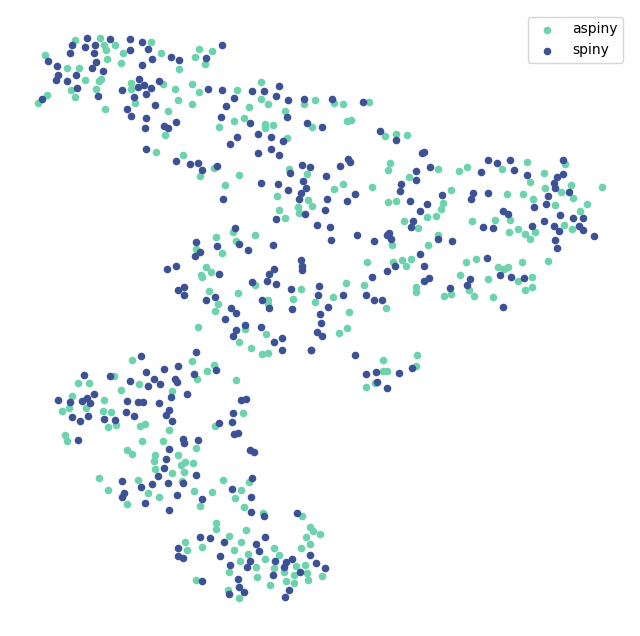

In [35]:
plot_tsne(z, np.concatenate([np.zeros(286, dtype=int), np.ones(330, dtype=int)]), targets=['aspiny', 'spiny'], colors=[colors[1], colors[0]])

In [36]:
def plot_tsne(z, labels, targets, colors=None):
    """ Plot t-SNE clustering. """
    u_labels = np.unique(labels)
    fig = plt.figure(1, figsize=(8, 8))
    for label in u_labels:
        plt.scatter(z[labels == label, 0], 
                    z[labels==label, 1], 
                    s=20, 
                    label=str(targets[label]),
                    color=colors[label])
        
    plt.legend(bbox_to_anchor=(1,1))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('tsne.pdf', format='pdf', dpi=600)

In [37]:
cls_target_all

array([0, 1, 2, 1, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 0, 0, 0, 1, 1, 2,
       2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 2,
       2, 0, 1, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       2, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,

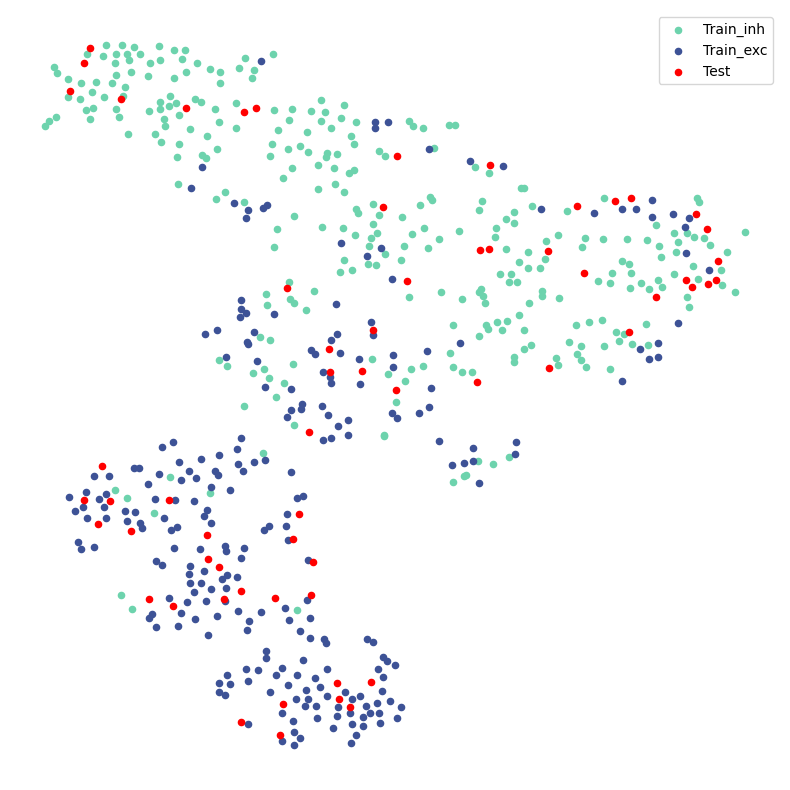

In [38]:
plot_tsne(z, labels = cls_target_all, targets=['Train_inh', 'Train_exc', 'Test'],colors=[colors[1], colors[0], 'red']) #'#ff4500'])

In [41]:
train_latents = latents[target == 0]
test_latents = latents[target == 1]
train_target = cls_target[target == 0]
test_target = cls_target[target == 1]

In [42]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(train_latents, train_target)
pred_test_targets = neigh.predict(test_latents)
accuracy = np.mean(test_target == pred_test_targets)
accuracy

0.9180327868852459

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_target, pred_test_targets)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title("No_PE")
plt.ylabel("Predicted classes")
plt.xlabel("True classes")
plt.xticks(np.arange(len(cm)) + 0.5, labels=["inh", "exc"])
plt.yticks(np.arange(len(cm)) + 0.5, labels=["inh", "exc"])
plt.tight_layout()

plt.tight_layout()
plt.savefig('confusion_matrix.pdf', format='pdf', dpi=600)

plt.close()

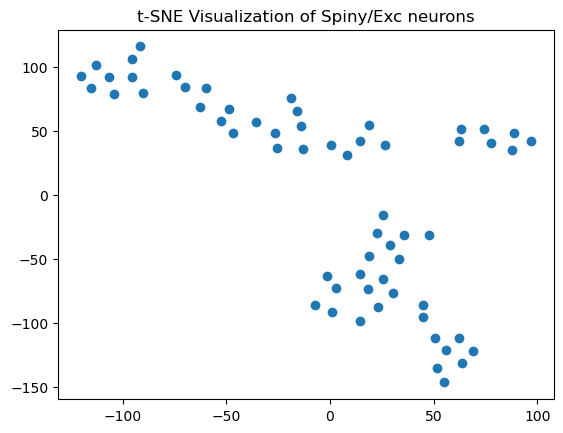

In [44]:
spiny = latents[target==1]
s = TSNE(n_components=2, perplexity=10).fit_transform(spiny)
plt.scatter(s[:, 0], s[:, 1])
plt.title('t-SNE Visualization of Spiny/Exc neurons')
plt.show()

In [47]:
from sklearn.cluster import KMeans

n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(latents)

In [48]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(latents, clusters)
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.31625194557980396


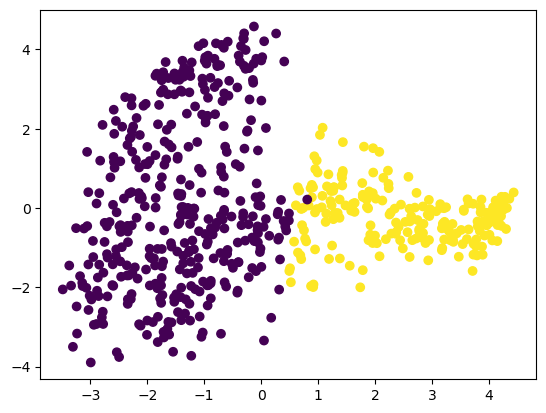

In [49]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latents)
cluster_assignments = kmeans.labels_


plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=cluster_assignments)

In [50]:
mask = test_target != pred_test_targets
pred_test_targets_new = np.copy(pred_test_targets)

pred_test_targets_new[mask & (pred_test_targets == 0)] = 4
pred_test_targets_new[mask & (pred_test_targets == 1)] = 5
pred_test_targets_new

array([0, 1, 1, 1, 1, 0, 4, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 4, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 5, 1, 0, 1, 0, 1, 1, 1, 0, 5, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 4, 0, 1, 1])

In [51]:
cls_target_5 = np.copy(cls_target_all)
idx_of_2 = np.where(cls_target_all == 2)[0]

for i in range(len(pred_test_targets_new)):
    if pred_test_targets_new[i] == 0:
        cls_target_5[idx_of_2[i]] = 2
    elif pred_test_targets_new[i] == 1:
        cls_target_5[idx_of_2[i]] = 3
    else:
        cls_target_5[idx_of_2[i]] = pred_test_targets_new[i]
#cls_target_5 
#0 and 1 = train_inh and exc
#2 and 3 = test_ing and exc correct
#4 and 5 = test_inh and exc incorrect

In [58]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np

def plot_tsne(z, labels, targets, colors=None):
    """ Plot t-SNE clustering. """
    u_labels = np.unique(labels)
    fig = plt.figure(1, figsize=(8, 8))
    ax = plt.gca()
    for label in u_labels:
        if label in [4, 5]:
            points = z[labels == label]
            for point in points:
                aspect_ratio = ax.get_data_ratio()
                ellipse = Ellipse(xy=point, width=1.8, height=1.8*aspect_ratio, edgecolor='red', facecolor='none')
                plt.gca().add_patch(ellipse)
        
        plt.scatter(z[labels == label, 0], 
                    z[labels == label, 1], 
                    s=20, 
                    label=str(targets[label]),
                    color=colors[label])
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('tsne.pdf', format='pdf', dpi=600)

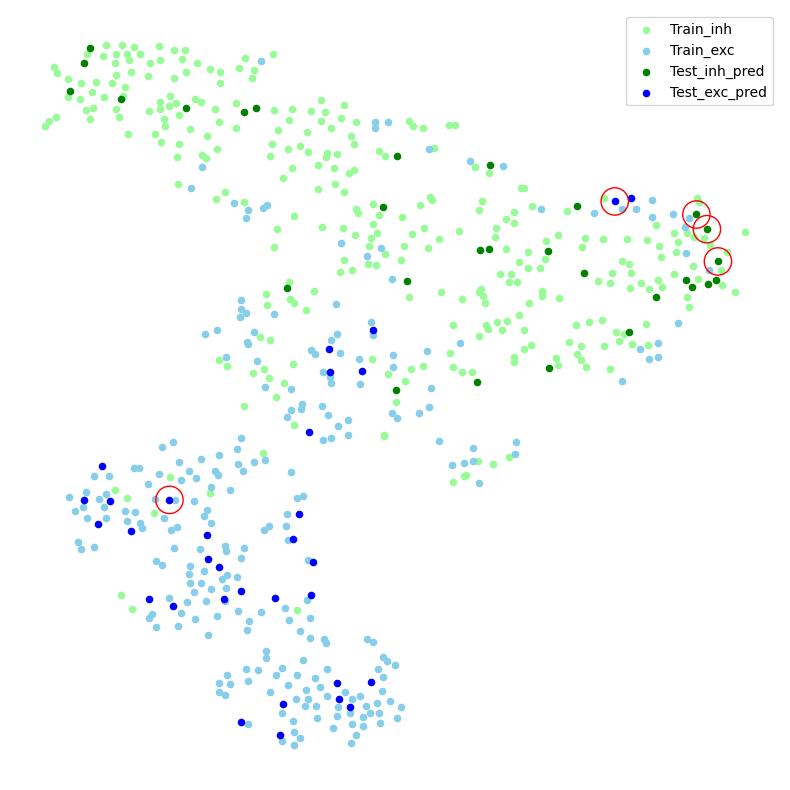

In [59]:
plot_tsne(z, labels = cls_target_5, targets=['Train_inh', 'Train_exc', 'Test_inh_pred', 'Test_exc_pred', '', ''],colors=['palegreen', 'skyblue', 'green', 'blue', 'green', 'blue']) #'#ff4500'])